In [1]:
import cv2
import numpy as np
import pcl
import json
import freenect
import frame_convert2
import matplotlib.pylab as plt
import matplotlib
import imutils 

import redis
import frame_convert2
import importlib
import time
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit

In [2]:
r = redis.Redis(charset='utf-8', decode_responses=True)
simulation = False
if simulation:
    JOINT_ANGLES_KEY = "sai2::cs225a::panda_robot::sensors::q"
    JOINT_VELOCITIES_KEY = "sai2::cs225a::panda_robot::sensors::dq"
    JOINT_TORQUES_COMMANDED_KEY = "sai2::cs225a::panda_robot::actuators::fgc"
    # 
    CURRENT_POSITION_KEY = "sai2::cs225a::panda_robot::sensors::current_position"
    TARGET_POSITION_KEY = "sai2::cs225a::panda_robot::control::target_position"
else:    
    JOINT_TORQUES_COMMANDED_KEY = "sai2::FrankaPanda::actuators::fgc"
    JOINT_ANGLES_KEY  = "sai2::FrankaPanda::sensors::q"
    JOINT_VELOCITIES_KEY = "sai2::FrankaPanda::sensors::dq"
    JOINT_TORQUES_SENSED_KEY = "sai2::FrankaPanda::sensors::torques"
    MASSMATRIX_KEY = "sai2::FrankaPanda::sensors::model::massmatrix"
    CORIOLIS_KEY = "sai2::FrankaPanda::sensors::model::coriolis"
    ROBOT_GRAVITY_KEY = "sai2::FrankaPanda::sensors::model::robot_gravity"
    # 
    CURRENT_POSITION_KEY = "sai2::FrankaPanda::sensors::current_position"
    TARGET_POSITION_KEY = "sai2::FrankaPanda::control::target_position"
    CALI_DONE_KEY = "sai2::FrankaPanda::control::cali_done"
    BALL_POSITION_KEY  = 'sai2::cs225a::cv::ball_position::xyz'
    BALL_TIMESTAMP_KEY = 'sai2::cs225a::cv::ball_position::time'

# Conversion between Redis key-value format to numpy arrays
 
def str_to_vec(s):
    return np.array([float(x) for x in s[1:-1].split(',')])

def key_to_vec(r, key_name):
    return str_to_vec(r.get(key_name))

def vec_to_str(v):
    return '[' + ','.join(x for x in v) + ']'

In [3]:
fx, fy = 529.215, 525.5639
cx, cy = 328.942, 267.480
MAX_ALLOWED_DEPTH = 4 # meters


In [4]:
# Get raw depth and RGB image using libfreenect driver

def get_depth():
    """
    Get depth image in millimeters (valued 0-10000)
    """
    value = freenect.sync_get_depth(format=freenect.DEPTH_REGISTERED)[0]
    return value

def get_video():
    """
    Get BGR frames (valued 0-255)
    """
    return frame_convert2.video_cv(freenect.sync_get_video()[0])

reference_color = np.array([178, 181, 60]) / 255.
reference_color_dark = np.array([171, 174, 102]) / 255.
hue = matplotlib.colors.rgb_to_hsv(reference_color)[0]
hue_dark, sat_dark, val_dark = matplotlib.colors.rgb_to_hsv(reference_color)
    
def find_color_pixel_mask(rgb):
    hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV) / 255.
    hue_hsv, sat_hsv, bright_hsv = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]
    
    height, width = hsv.shape[0], hsv.shape[1]
    grid = np.zeros((height, width), dtype=np.uint8)    
    grid[(hue_hsv < (hue + 10 / 360.)) & (hue_hsv > (hue - 25 / 360.)) & \
         (sat_hsv > 0.4) & (bright_hsv > 0.35)] = 255
    
    grid[(hue_hsv < (hue_dark + 15 / 360.)) & (hue_hsv > (hue_dark - 25 / 360.)) & \
         (bright_hsv > 0.35)] = 255
    return grid

def to_xyz(rgb, depth):
    z = depth[rgb[:, 0], rgb[:, 1]]
    x = ((rgb[:, 1] - cx) * z) / fx
    y = ((rgb[:, 0] - cy) * z) / fy
    x, y, z = x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)
    xyz = np.hstack([x, y, z])
    xyz = xyz.astype(np.float32)
    return xyz[xyz[:, 2] > 0]

def to_uv(x, y, z):
    u = fx * x / z + cx
    v = fy * y / z + cy
    return u, v
    

def find_contour(mask, rgb):
    contours = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)
    ((x, y), radius) = cv2.minEnclosingCircle(c)
    return (x, y), radius

def get_mask_ball(mask, center, radius, depth):
    x, y = center
    mask_circle = np.zeros(mask.shape, dtype=np.uint8)
    mask_circle = cv2.circle(mask_circle, (int(x), int(y)), int(radius * 1.5), 255, thickness=-1)
    mask_ball_color = mask_circle & mask 
    mask_ball_color = mask_ball_color & (depth > 0) & (depth < MAX_ALLOWED_DEPTH)
    
    mbc_sum = np.count_nonzero(mask_ball_color)
    mc_sum = np.count_nonzero(mask_circle)    

    area = mbc_sum / mc_sum
    # print(mbc_sum, area)
    if mbc_sum < 20 or area < 0.2:
        return None
    else:
        return mask_ball_color

def get_foreground_from_mask(center, radius, depth):
    x, y = center
    x, y, radius = int(x), int(y), int(radius)
    subimg = depth[y-radius:y+radius, x-radius:x+radius]
    mask = (subimg > 0) & (subimg < MAX_ALLOWED_DEPTH)
    positions = np.argwhere(mask > 0)
    sub_depth = np.array([subimg[u, v] for u, v in positions]).reshape(-1, 1)
    if len(positions) > 0:
        kmeans = KMeans(n_clusters=2, random_state=0).fit(sub_depth)
        argmin = np.argmin(kmeans.cluster_centers_)
        return positions[kmeans.labels_ == argmin] + [y-radius, x-radius]
    else:
        return None
    
def filter_outlier(pc):
    n_pc = len(pc)
    cloud = pcl.PointCloud()
    cloud_filtered = pcl.PointCloud()
    cloud.from_array(pc)

    kdtree = cloud.make_kdtree_flann()
    [ind, sqdist] = kdtree.nearest_k_search_for_cloud(cloud, int(n_pc / 10))    
    valid_mask = sqdist.max(axis=-1) < 1e-2
    pc_filtered = pc[valid_mask]
    return pc_filtered

def fit_ball(X):
    """
    input:
        X: (n, 3) np.array 
    output:
        r, (x, y, z)
    """
    assert(X.shape[1] == 3)
    
    A = np.average(X, axis=0)
    Y = X - A
    sum_yyt = np.sum(np.apply_along_axis(np.linalg.norm, 1, Y) ** 2)
    yty = [Y[i].reshape(3, 1) @ Y[i].reshape(1,3) for i in range(Y.shape[0])]
    C = A + 1.0 / ( 2 * sum_yyt ) * np.sum([y @ Y[i] for i, y in enumerate(yty)])
    r = np.mean(np.linalg.norm(C - X, axis=1))
    return C, r

# https://jekel.me/2015/Least-Squares-Sphere-Fit/
def sphereFit(spX,spY,spZ):
    #   Assemble the A matrix
    spX = np.array(spX)
    spY = np.array(spY)
    spZ = np.array(spZ)
    A = np.zeros((len(spX),4))
    A[:,0] = spX*2
    A[:,1] = spY*2
    A[:,2] = spZ*2
    A[:,3] = 1

    #   Assemble the f matrix
    f = np.zeros((len(spX),1))
    f[:,0] = (spX*spX) + (spY*spY) + (spZ*spZ)
    C, residules, rank, singval = np.linalg.lstsq(A, f, rcond=None)

    #   solve for the radius
    t = (C[0]*C[0])+(C[1]*C[1])+(C[2]*C[2])+C[3]
    radius = np.sqrt(t)

    try:
        return radius[0], C[0][0], C[1][0], C[2][0]
    except:
        return radius, C[0], C[1], C[2]
    
def find_ball(image=None, depth=None):
    if image is None or depth is None:
        image = get_video()
        depth = get_depth() / 1000

    color_mask = find_color_pixel_mask(image)
    center, radius = find_contour(color_mask, image)
    fg_mask = get_foreground_from_mask(center, radius * 1.5, depth)
    mask_ball = get_mask_ball(color_mask, center, radius, depth)

    # print(mask_ball)
    
    if fg_mask is None or mask_ball is None:
        raise Exception("ball not found")
    
    pc_mask = to_xyz(fg_mask, depth)
    pc_color = to_xyz(np.argwhere(mask_ball > 0), depth)
        
    mask_fg = np.zeros((480, 640))
    for x,y in fg_mask: mask_fg[x, y] = 0.5
    for x,y in np.argwhere(mask_ball > 0): mask_fg[x, y] += 0.5  
    # plt.imshow(mask_fg, cmap='gnuplot')
        
    rm, cxm, cym, czm = sphereFit(pc_mask[:, 0], pc_mask[:, 1], pc_mask[:, 2])
    rc, cxc, cyc, czc = sphereFit(pc_color[:, 0], pc_color[:, 1], pc_color[:, 2])
    rm_valid = rm > 0.01 and rm < 0.3
    rc_valid = rc > 0.01 and rc < 0.3
    
    if rm_valid and not rc_valid:
        return rm, cxm, cym, czm, 'm'
    if rc_valid and not rm_valid:
        return rc, cxc, cyc, czc, 'c'
    if rc_valid and rm_valid:
        return rc, cxc, cyc, czc, 'c'
    raise Exception("cannot find ball!")

In [72]:
cv2.__version__

'4.1.0'

In [68]:
a = np.array([1,2,3])
a.reshape(3,1).dot(a)

ValueError: shapes (3,1) and (3,) not aligned: 1 (dim 1) != 3 (dim 0)

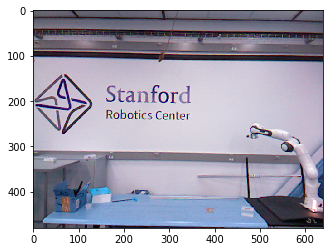

In [5]:
depth = get_depth() / 1000
rgb = get_video()
plt.imshow(rgb)

In [54]:
find_ball(rgb, depth)

(0.034654207123859304,
 -0.1731392372376873,
 -0.6709227709686595,
 1.7691390990864908,
 'm')

In [8]:
import os
frames = []
depths = []
balls = []

frame_id = 0
while frame_id < 180:
    try:
        depth = get_depth() / 1000
        rgb = get_video()

        try:
            r, x, y, z, t = find_ball(rgb, depth)
#             print(r, x, y, z, t)
            u, v = to_uv(x, y, z)
            # print(u, v)
            rgb_ = rgb[:]
            if t == 'm':
                rgb_ = cv2.drawMarker(rgb_, (int(u), int(v)), (255, 0, 0), thickness=6).get()
            else:
                rgb_ = cv2.drawMarker(rgb_, (int(u), int(v)), (0, 0, 255), thickness=6).get()
            frames.append(rgb_)
            balls.append((r, x, y, z))
        except:
            new_img = rgb.copy()
            frames.append(new_img)
            depths.append(depth.copy())
            balls.append(None)
    
        frame_id += 1
    except KeyboardInterrupt:
        break
    
if not os.path.exists('frame'):
    os.makedirs('frame')
if not os.path.exists('depth'):
    os.makedirs('depth')
for i in range(frame_id):
#     cv2.imwrite('depth/depth{:03d}.jpg'.format(i), depths[i])
    cv2.imwrite('frame/frame{:03d}.jpg'.format(i), frames[i])
    # plt.clf()
    # plt.imshow(depths[i], cmap='gist_rainbow', vmin=0, vmax=3.5)
    
    
# for i, j in enumerate(balls):
#     print(i, j)

/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)


In [65]:
balls[17]
   

(0.034929935319863076,
 -0.22425252065523635,
 -0.5724053170462411,
 1.7703966727080878)

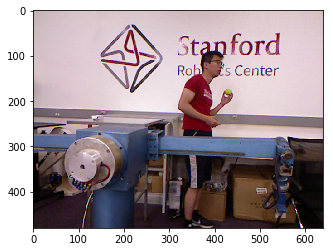

In [37]:
plt.imshow(rgb[:, :, [2, 1, 0]])

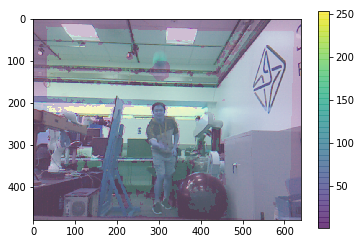

In [450]:
plt.imshow(depth, alpha=0.5)
plt.imshow(rgb, alpha=0.5)
plt.colorbar()

In [251]:
centroid = np.average(pc_color, axis=0)
np.average(np.linalg.norm(pc_color - centroid, axis=1))

0.037991565

In [119]:
def move_robot(target_xyz, velocity_threshold=1e-1, timeout=5.0):
    r.set(TARGET_POSITION_KEY, vec_to_str(target_xyz))
    start_time = time.time()
    
    while np.norm(key_to_vec(JOINT_VELOCITIES_KEY)) < velocity_threshold:
        curr_time = time.time()
        if curr_time - start_time > timeout:
            raise Exception("control timeout!")

    return key_to_vec(CURRENT_POSITION_KEY)

In [7]:
target_coords = [[0.35, 0.4, 0.3], [0.35, -0.4, 0.3], [0.45, 0.3, 0.8], [0.45, -0.3, 0.8]]

def get_coords(target_coords):
    results_camera = []
    results_robot  = []
    for target_xyz in target_coords:
        try:
            r_robot = move_robot(target_xyz) # tune params! 
            _ = input("Please press a key...")
            r_camera = find_ball()
            results_camera.append(r_camera)
            results_robot.append(r_robot)
        except Exception as e:
            print("{} failed!".format(target_xyz))
            print(e)
    return results_camera, results_robot

In [8]:
def optimize_transformation(xyzs_camera, xyzs_robot):
    """
    args: 
      xyzs_camera = (N, 3) numpy array, containing points in camera frame
      xyzs_robot  = (N, 3) numpy array, containing points in robot frame
    returns:
      T = [4, 4] including a transformation matrix converting camera frame to robot frame
        = [[R(3x3) , t(3x1)],
           [0, 0, 0,      1]]
    """
    centroid_frame_camera = np.mean(xyzs_camera, axis=0)
    centroid_frame_robot  = np.mean(xyzs_robot, axis=0)
    H = (xyzs_camera - centroid_frame_camera).T @ (xyzs_robot - centroid_frame_robot)
    U, S, V = np.linalg.svd(H)
    R = (U @ V).T
    t = centroid_frame_robot - R @ centroid_frame_camera
    return np.hstack([np.vstack([R.T, t]), np.array([[0, 0, 0, 1]]).T]).T

# Check Transformation Matrix Quality

In [33]:
import numpy as np
from scipy.linalg import lstsq
def check_transformation_matrix(optimize_transformation, num_points, point_scale=5, gaussian_scale=0.3):
    T_1_to_2 = np.array([
        [0.07143, -0.6589, 0.7488, -3], 
        [0.9446, 0.2857, 0.1613, 5],
        [-0.3202, 0.6958, 0.6429, 7], 
        [0, 0, 0, 1]
    ])
    
    points_frame_1 = np.random.rand(num_points, 3) * point_scale
    points_frame_2 = np.pad(points_frame_1, [(0, 0), (0, 1)], 'constant', constant_values=1) @ T_1_to_2.T
    noise = np.random.normal(loc=0.0, scale=gaussian_scale, size=points_frame_2.shape)
    noise[:, 3] = 0
    points_frame_2_noise = points_frame_2 + noise
    
    points_frame_2_ = points_frame_2[:, :3]
    points_frame_2_noise_ = points_frame_2_noise[:, :3]
    
    T_calculated = optimize_transformation(points_frame_1, points_frame_2_noise_)
    points_frame_2_est = np.pad(points_frame_1, [(0, 0), (0, 1)], 'constant', constant_values=1) @ T_calculated.T
    points_frame_2_est = points_frame_2_est[:, :3]
    
    print(f'Original T: \n{T_1_to_2}')
    print(f'Calculated T: \n{T_calculated}')
    print(f'|T[Orig] - T[Calc]| = {np.linalg.norm(T_calculated - T_1_to_2)}\n')
    print(f'Average(T[calc].P - T[orig].P) = {np.mean(points_frame_2_est - points_frame_2_, axis=0)}')

## Usage

In [39]:
check_transformation_matrix(optimize_transformation, num_points=20, point_scale=5, gaussian_scale=0.1)

Original T: 
[[ 0.07143 -0.6589   0.7488  -3.     ]
 [ 0.9446   0.2857   0.1613   5.     ]
 [-0.3202   0.6958   0.6429   7.     ]
 [ 0.       0.       0.       1.     ]]
Calculated T: 
[[ 0.067582   -0.66036386  0.74789855 -3.01267683]
 [ 0.9432136   0.28664982  0.16786893  4.99561748]
 [-0.32523956  0.69408317  0.64223655  7.03446348]
 [ 0.          0.          0.          1.        ]]
|T[Orig] - T[Calc]| = 0.03821207557344279

Average(T[calc].P - T[orig].P) = [-0.02794619  0.01017478  0.01618916]


In [2]:
import KF
import numpy as np

In [ ]:
kf = KF(mu0=, sigma0, C, Q, R, g, delta_t)